# Importing Libraries

In [1]:
from functions.adversarial import *
from functions.dip import *
from functions.classification import *
import matplotlib.pyplot as plt
import cv2
import numpy as np
from functions.utils import *
from functions.saliency import *

#device = torch.device("cuda" if torch.cuda.device_count() else "cpu")

the trial number is: 0
the trial number is: 1
the trial number is: 2
the trial number is: 3
the trial number is: 4
the trial number is: 5
the trial number is: 6
the trial number is: 7
the trial number is: 8
the trial number is: 9


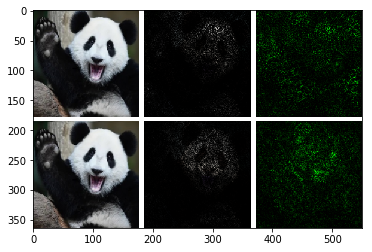

In [2]:
images = 'panda.jpg'
  
#generate_saliency_maps('results/Adv_DIP/Multiple_images/panda', img, 10001)
generate_saliency_maps('data', images)

In [ ]:
img = cv2.imread("data/goldfish.jpg")
print(img.shape)
img = img[:, :, (2, 1, 0)]
print(img.shape)
print(img)

In [ ]:
images = ['panda.jpg', 'peacock.jpg', 'F16_GT.png', 'monkey.jpg', 'zebra_GT.png', 'goldfish.jpg']
for i in images:
    orig = cv2.imread("data/{}".format(i))[..., ::-1]
    orig = cv2.resize(orig, (224, 224))
    img = orig.copy().astype(np.float32)
    classification(img)

In [ ]:
net_input = get_noise(3, 'noise', (224, 224))
print(net_input)
print(net_input.shape)
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = 
net_input = global_values.net_input_saved + (global_values.noise.normal_() * global_values.noise_std)

# Fast Gradient Descent Method

In [ ]:
adv1, orig, pert = adversarial_examples('data/goldfish.jpg', method='FGSM',eps=100,show=False)

# Basic Iterative Method

In [ ]:
adv2, orig, pert = adversarial_examples('data/goldfish.jpg',method='BI',eps=100,show=False)

# Least Likely Class Iterative

In [ ]:
adv3, orig, pert = adversarial_examples('data/goldfish.jpg',method='LLCI',eps=100,show=False)

## Some plotting

In [ ]:
fig=plt.figure(figsize=(16,16))

fig.add_subplot(1, 3, 1)
plt.title('FGSM')
plt.imshow(adv1)

fig.add_subplot(1, 3, 2)
plt.title('BI')
plt.imshow(adv2)

fig.add_subplot(1, 3, 3)
plt.title('LLCI')
plt.imshow(adv3)

plt.show()

## Save images
plt.imsave("results/Goldfish_fgsm_eps100.png", adv1, format="png")
plt.imsave("results/Goldfish_bi_eps100.png", adv2, format="png")
plt.imsave("results/Goldfish_llci_eps100.png", adv3, format="png")

# Using Deep Image Prior

In [ ]:
orig = cv2.imread("data/lighthouse.jpg")[..., ::-1]
orig = cv2.resize(orig, (256, 256))
img = orig.copy().astype(np.float32)

## Save images
#plt.imsave("results/F16_noisy.png", np.clip(img_noisy, 0, 1), format="png")
#plt.imsave("results/F16.png", np.clip(img, 0, 1), format="png")

dip_out = dip(img, num_iter=10001, save=False, plot=False, save_path='results/Adv_DIP/', arch='complex')

# Observing general images

In [ ]:
i=20
orig = cv2.imread("results/Adv_DIP/FGSM_eps100/it_{}.png".format(i*100))[..., ::-1]
orig = cv2.resize(orig, (256, 256))
img = orig.copy().astype(np.float32)
P,R = classification(img)
plt.imshow(orig) 

In [ ]:
std = 150
value = 100

adv, orig, pert = adversarial_examples('data/goldfish.jpg',model_name = 'resnet18', method='FGSM',eps=value, show=False)
adv_noisy = adv + std*np.random.randn(224,224,3)
adv_noisy = np.clip(adv_noisy,0,255).astype(np.uint8)
plt.imshow(adv_noisy)
plt.show()

In [ ]:
it_300 = cv2.imread("results/Adv_DIP/LLCI_eps5/it_{}.png".format(300))[..., ::-1]
it_1200 = cv2.imread("results/Adv_DIP/LLCI_eps5/it_{}.png".format(1200))[..., ::-1]
it_2500 = cv2.imread("results/Adv_DIP/LLCI_eps5/it_{}.png".format(5000))[..., ::-1]
orig = cv2.imread('data/panda.jpg')[...,::-1]

P,R = classification(orig)
P,R = classification(it_300)
P,R = classification(it_1200)
P,R = classification(it_2500)

## Classifying

In [ ]:
# Find original classification class
iterations = 9101
#adv, orig, pert = adversarial_examples('data/goldfish.jpg',model_name = 'resnet18', method='LLCI',eps=100, show=False)
P, R = classification(orig, model_name = 'resnet18', sort = True, show=False)
original_class = R[0,0]
P, R = classification(adv, model_name = 'resnet18', sort = True, show=False)
final_classes = R[0,0:5]

# Create matrix to store values
Confidence = np.ones([round((iterations-1)/100+1),6])
Ranks_matrix = np.ones([round((iterations-1)/100+1),5])


for i in range(round((iterations-1)/100+1)):
    orig = cv2.imread("results/Adv_DIP/Complex_LLCI_eps5/it_{}.png".format(i*100))[..., ::-1]
    orig = cv2.resize(orig, (256, 256))
    img = orig.copy().astype(np.float32)
    Probs, Ranks = classification(img, model_name = 'resnet18', sort = False, show = False)
    Probs_np = torch_to_np(Probs)
    Confidence[i,0] = Probs_np[original_class]
    P , Ranking = Probs.sort(descending=True)
    Ranking_np = torch_to_np(Ranking)
    for j in range(5):
        Confidence[i,j+1] = Probs_np[final_classes[j]]
        Ranks_matrix[i,j] = Ranking_np[j]  

In [ ]:
it = np.arange(0, iterations+99, 100)
iters = round((iterations-1)/100+1)
fig = plt.figure(figsize=(6, 6))
plt.xlabel('DIP Iterations')
plt.ylabel('Confidence of true class')
plt.plot(it,Confidence)
plt.show()

# Save stuff
fig.savefig('results/Adv_DIP/Simple_LLCI_eps5/Graph_Complex_LLCI_eps100_full.png')
np.savetxt('results/Adv_DIP/Simple_LLCI_eps5/Complex_LLCI_eps100_full.txt', Confidence)
np.savetxt('results/Adv_DIP/Simple_LLCI_eps5/Complex_LLCI_eps100_ranks.txt', Ranks_matrix)
for i in range(5):
    print(classes[int(Ranks_matrix[-1,i])].split(',')[0])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import cv2
#import argparse
import numpy as np
from functions.utils import *
from functions.adversarial import *
from functions.dip import *
from functions.classification import *


for i in ['panda.jpg']:
    adv, orig, pert = adversarial_examples("data/{}".format(i), method = "FGSM", eps=1, show=False)
    out = dip(adv, num_iter=51, save=True, plot=True, save_path='results/Adv_DIP', arch='simple')

In [ ]:
save_path_common = 'results/Adv_DIP/Architecture_tests/{}'
print(save_path_common.format('Adam/test{}'.format(1)))

In [ ]:
for j in range(1,4):
    print(j)